# FFT-Based Audio Watermarking

For our final project, we have decided to implement an audio watermarking algorithm

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import binascii
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft, fftfreq, fftshift, rfft, irfft, ifftshift

First, we read the 

In [21]:
sr, original = read('audio/speech.wav')
N = len(original)

print(f"Sampling Rate is {sr} Hz")
print(f"Total number of samples is {N}")

Sampling Rate is 44100 Hz
Total number of samples is 220500


Now, we can listen to the original audio file.

In [22]:
Audio(original, rate=sr)

By plotting the spectrogram, 

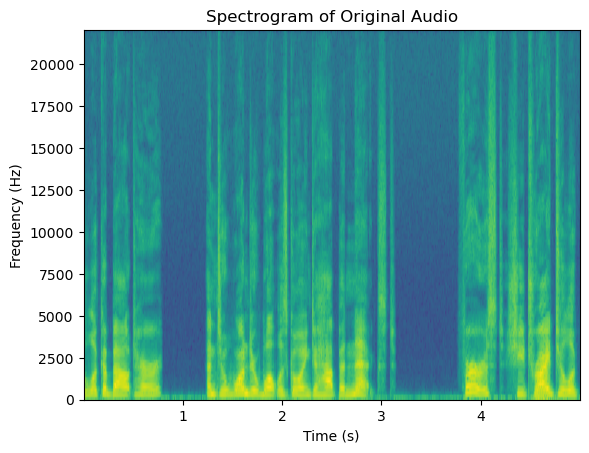

In [23]:
plt.figure()
plt.specgram(original, Fs=sr)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of Original Audio')
plt.savefig('output/original.png')
plt.show()

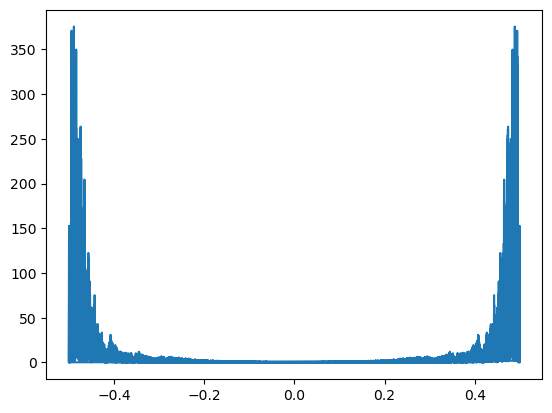

In [24]:
original_ft = fftshift(fft(original, N))
original_ft_freq = fftfreq(original.size)
plt.plot(original_ft_freq, abs(original_ft))

# Embed Watermark

In order to embed a watermark into our audio file, 

In [25]:
watermark = "EECS351" # replace with your chosen watermark
watermark_bits = ''.join(format(ord(i), '08b') for i in watermark)

print(f"Watermark: {watermark}")
print(f"Binary array to embed: {watermark_bits}")

Watermark: EECS351
Binary array to embed: 01000101010001010100001101010011001100110011010100110001


In [26]:
frame = len(watermark_bits) # total number of bits to embed
d = 10 # number of samples used to embed each bit
p = frame * d # total number of samples to embed
center = (N/2) + 1

embed_freq = 5000

X_mag = np.abs(original_ft)
X_phase = np.angle(original_ft)

Y = X_mag
X_embed = X_mag[int(center - embed_freq - p):int(center - embed_freq)]

a = 0.1

X_mat = X_embed.reshape(frame, d) 

The selected band is divided into short frames and a single secret bit is embedded into each frame. Based on the corresponding secret bit, all samples in each frame should be changed by the average of all samples or the average multiplied by a factor. If the secret bit is 0, all FFT magnitudes in the frame should be changed to the average of all FFT magnitudes in the frame. If the secret bit is 1, we divide the FFT samples in the frame into two groups based on the sequence and, then change the magnitude of the first group using a scale factor (VALUE) and the magnitude of the second group multiplying VALUE by the average.

In [27]:
for k in range(frame):
    avg = 0
    
    # take average of the samples in given frame
    for l in range(d):  
        avg = avg + X_mat[k][l]
    avg = avg / d

    if watermark_bits[k] == '0':  # if the bit to encode is '0'
        print('0', end=' ')
        for l in range(d):
            # set all 10 samples to same average value - indicates 0 bit
            X_mat[k][l] = avg

    else:  # if the bit to encode is '1'
        print('1', end=' ')
        for l in range(int(d / 2)):  # access the first half of the frame
            X_mat[k][l] = a * avg  # set FFT samples to scaled average value
        for l in range(int(d / 2), d):  # access the second half of the frame
            X_mat[k][l] = (2 - a) * avg  # set FFT samples to scaled average value

0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 

In [28]:
X_vec = X_mat.reshape(p)  # bring it back to vector/array

# define range for adding embeddings back to final fft vec with embeddings
range_embed_1 = range(int(center - embed_freq -p), int(center - embed_freq))
range_embed_2 = range(int(center + embed_freq + 1),
                      int(center + embed_freq + p + 1))

Y[range_embed_1] = X_vec
Y[range_embed_2] = X_vec[::-1]  # reversed X_vec for symmetry

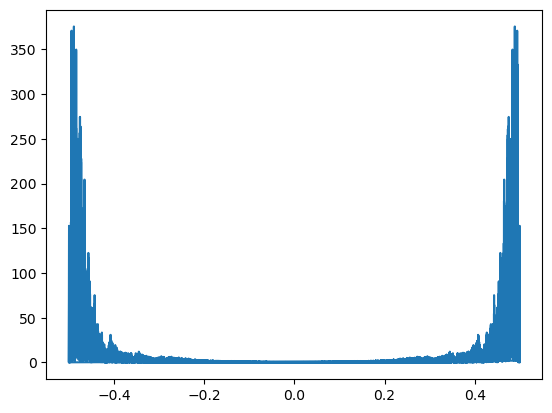

In [29]:
Y1 = np.multiply(Y, np.exp(1j * X_phase))
plt.plot(original_ft_freq, abs(Y1))

In [30]:
watermarked = ifft(ifftshift(Y1))
write('output/watermarked.wav', int(sr), watermarked.real)

In [31]:
Audio(watermarked.real, rate=sr)

# Decode Watermark

In [32]:
sr, watermarked = read('output/watermarked.wav')
N = len(watermarked)

print(f"Sampling Rate is {sr} Hz")
print(f"Total number of samples is {N}")

Sampling Rate is 44100 Hz
Total number of samples is 220500


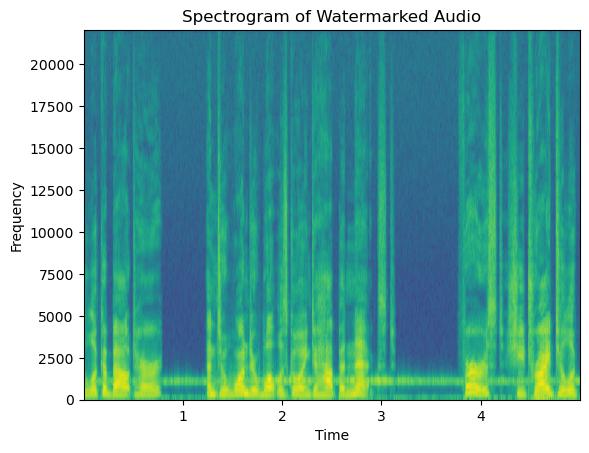

In [33]:
plt.figure()
plt.specgram(watermarked, Fs=sr)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of Watermarked Audio')
plt.savefig('output/watermarked.png')
plt.show()

In [34]:
Y2 = fftshift(fft(watermarked))
# values that are required to find embedding
# required_old_variables = [p, frame, d, a, embed_freq]

In [35]:
Y2_abs = abs(Y2)
# find in correct frequency window
detect_window = Y2_abs[int(center - embed_freq - p):int(center - embed_freq)]
detect_window_mat = detect_window.reshape(frame, d)  # reshape
recovered_binary = ''  # binary string

In [36]:
for k in range(frame):
    avg = 0
    one_count = 0
    zero_count = 0

    for l in range(d):  # find average
        avg = avg + detect_window_mat[k][l]
    avg = avg / d 

    # checking the first half of the frame
    for l in range(int(d / 2)):
        if (detect_window_mat[k][l] >= (1 + a) * avg / 2):  # decision for '0'
            zero_count += 1
        else:
            one_count += 1

    # checking the second half of the frame
    for l in range(int(d / 2), d - 1):
        if (detect_window_mat[k][l] < (3 - a) * avg / 2):
            zero_count += 1
        else:
            one_count += 1

    # final bit decision
    if (one_count > zero_count):
        recovered_binary = recovered_binary + '1'
    else:
        recovered_binary = recovered_binary + '0'

In [37]:
recovered_watermark = binascii.unhexlify(
    '%x' % int(recovered_binary, 2)).decode('utf-8')

print(f"Recovered binary array is {recovered_binary}")
print(f"Recovered watermark is {recovered_watermark}")

Recovered binary array is 01000101010001010100001101010011001100110011010100110001
Recovered watermark is EECS351
